In [1]:
from ucimlrepo import fetch_ucirepo 
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Funzione per l'utilizzo dei classificatori

In [2]:
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, name="Modello"):
    # Addestramento
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Stampa risultati
    scores_dict = {'Training Set': acc_train, 'Test Set': acc_test}
    scores = pd.DataFrame(scores_dict, index=['Accuracy'])
    display(scores)
    
    # Visualizza matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.show()

    y_pred_df = pd.DataFrame({
                          'True Class': y_test,
                          'Pred. Class': y_pred_test, 
                          'P(Class 0) - %': np.round(y_pred_proba[:, 0] * 100, decimals=2), 
                          'P(Class 1) - %': np.round(y_pred_proba[:, 1] * 100, decimals=2), 
                          'P(Class 2) - %': np.round(y_pred_proba[:, 2] * 100, decimals=2),
                          'P(Class 3) - %': np.round(y_pred_proba[:, 3] * 100, decimals=2),
                          'P(Class 4) - %': np.round(y_pred_proba[:, 4] * 100, decimals=2)})
    display(y_pred_df)

    display(y_pred_df[y_pred_df['True Class'] == 2])

# Importazione dei dati e creazione del dataframe

In [3]:
nursery = fetch_ucirepo(id=76) 

X = nursery.data.features 
y = nursery.data.targets

In [4]:
nursery_dataframe = pd.concat([X, y], axis=1)

display(nursery_dataframe)

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


# One-hot encoding #

In [5]:
# Copia del dataframe originale
nursery_dataframe_old = nursery_dataframe.copy()
onehot_cols = nursery_dataframe.columns.to_list()[:-1]

#Label encoding
labelenc_class = LabelEncoder()
labelenc_class.fit(nursery_dataframe['class'].values)
nursery_dataframe['class'] = labelenc_class.transform(nursery_dataframe['class'].values)

# One-hot encoding
nursery_dataframe = pd.get_dummies(nursery_dataframe, columns=onehot_cols)

#nursery_dataframe.to_csv("nursery_dataframe.csv", index=False)

display(nursery_dataframe)

,class,parents_great_pret,parents_pretentious,parents_usual,has_nurs_critical,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_complete,...,housing_critical,housing_less_conv,finance_convenient,finance_inconv,social_nonprob,social_problematic,social_slightly_prob,health_not_recom,health_priority,health_recommended
0,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
1,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,True,False
2,0,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
3,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
4,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,False,True,False
12956,0,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,True,False,False
12957,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,False,True
12958,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,True,False


In [6]:
X = nursery_dataframe.iloc[:,1:].values
y = nursery_dataframe['class'].values

# Divisione del dataset in train e test

In [7]:
random_state = 42
np.random.seed(random_state)

test_p = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_p, random_state=random_state, shuffle=True, stratify = y)

display(pd.DataFrame({'X_trainval': X_train.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

print("Distribuzione delle classi (train):")
print(pd.Series(y_test).value_counts().sort_index())

,X_trainval,X_test
N. sanmples,6480,6480
N.features,27,27


Distribuzione delle classi (train):
0    2160
1    2133
2       1
3    2022
4     164
Name: count, dtype: int64


# PCA

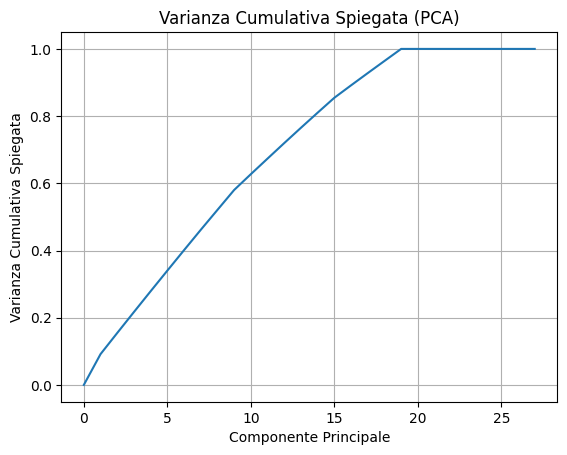

Numero di componenti principali selezionate: 17


In [8]:
# Inizializzazione oggetto PCA
explvar_p = 0.9
pca = PCA(n_components=explvar_p)

# "Fit" dell'oggetto PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# PCA per il grafico
pca_graph = PCA()
pca_graph.fit(X_train)

# Calcoliamo la varianza spiegata cumulativa
expld_variance = np.insert(np.cumsum(pca_graph.explained_variance_ratio_), 0, 0)

# Creiamo il grafico della varianza cumulativa
plt.figure()
plt.plot(expld_variance)
plt.title('Varianza Cumulativa Spiegata (PCA)')
plt.xlabel('Componente Principale')
plt.ylabel('Varianza Cumulativa Spiegata')

plt.grid()
plt.show()
print(f"Numero di componenti principali selezionate: {pca.n_components_}")

# Grafico LDA 2D su dati originali e su dati PCA-ridotti #

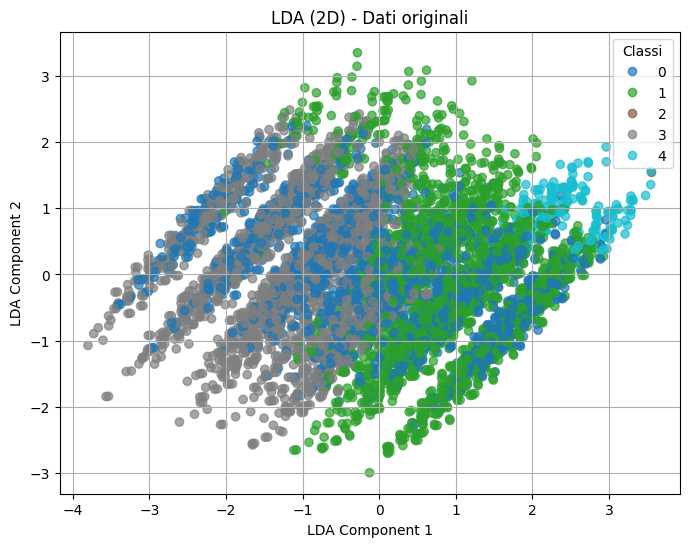

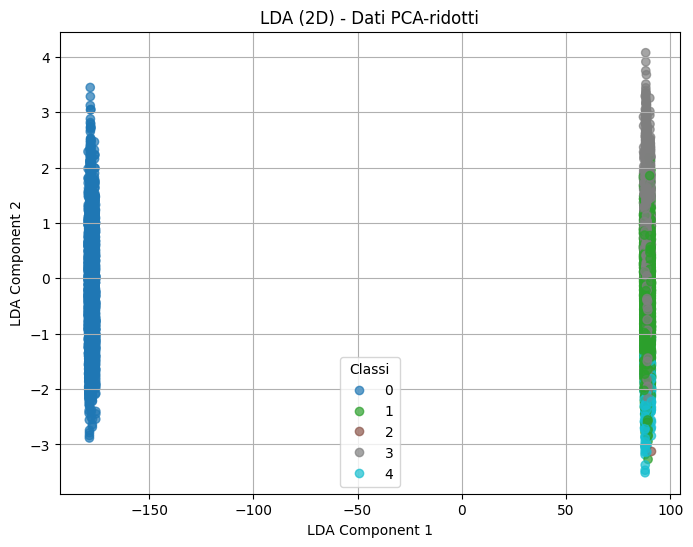

In [9]:
lda_vis = LDA(n_components=2)
X_lda_2d = lda_vis.fit_transform(X_train, y_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda_2d[:, 0], X_lda_2d[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.title("LDA (2D) - Dati originali")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.show()

lda_vis_pca = LDA(n_components=2)
X_lda_2d_pca = lda_vis_pca.fit_transform(X_train_pca, y_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda_2d_pca[:, 0], X_lda_2d_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.title("LDA (2D) - Dati PCA-ridotti")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.show()

# Grafici LDA 3D su dati originali e su dati PCA-ridotti #

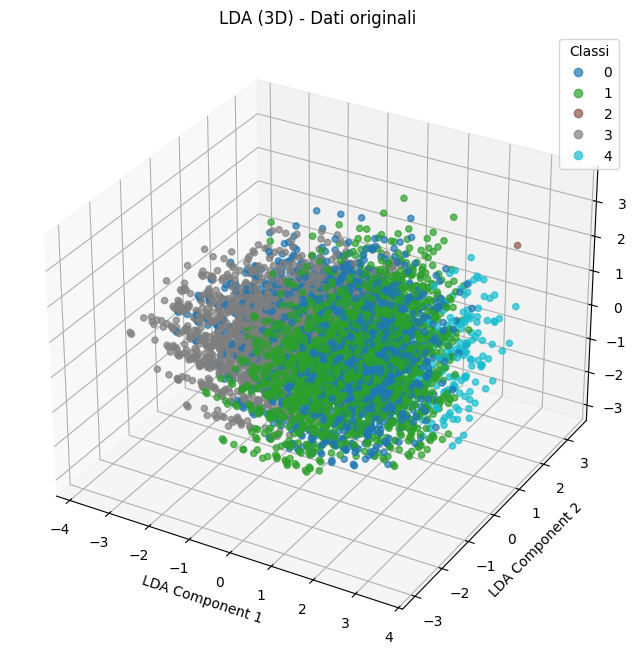

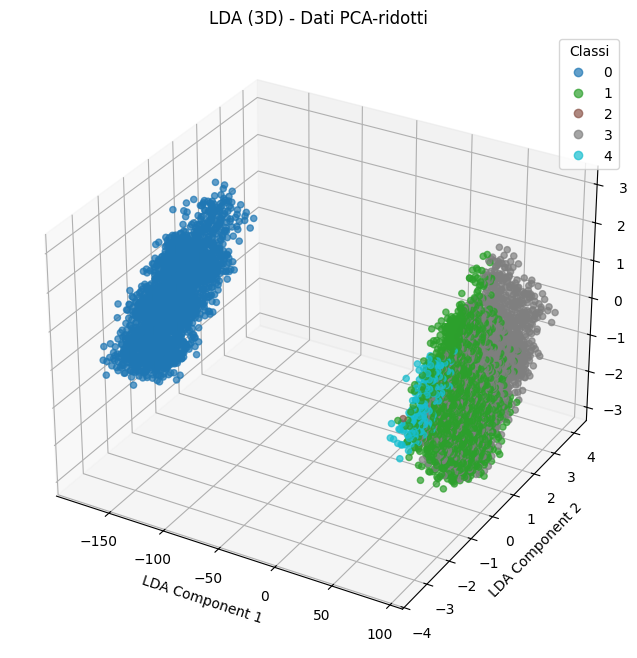

In [10]:
lda_3d = LDA(n_components=3)
X_lda_3d = lda_3d.fit_transform(X_train, y_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_lda_3d[:, 0], X_lda_3d[:, 1], X_lda_3d[:, 2], 
                     c=y_train, cmap='tab10', alpha=0.7)
ax.set_title("LDA (3D) - Dati originali")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
legend = ax.legend(*scatter.legend_elements(), title="Classi", loc="best")
plt.show()

lda_3d_pca = LDA(n_components=3)
X_lda_3d_pca = lda_3d_pca.fit_transform(X_train_pca, y_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_lda_3d_pca[:, 0], X_lda_3d_pca[:, 1], X_lda_3d_pca[:, 2], 
                     c=y_train, cmap='tab10', alpha=0.7)
ax.set_title("LDA (3D) - Dati PCA-ridotti")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
legend = ax.legend(*scatter.legend_elements(), title="Classi", loc="best")
plt.show()

# LDA come classificatore

,Training Set,Test Set
Accuracy,0.541512,0.550617


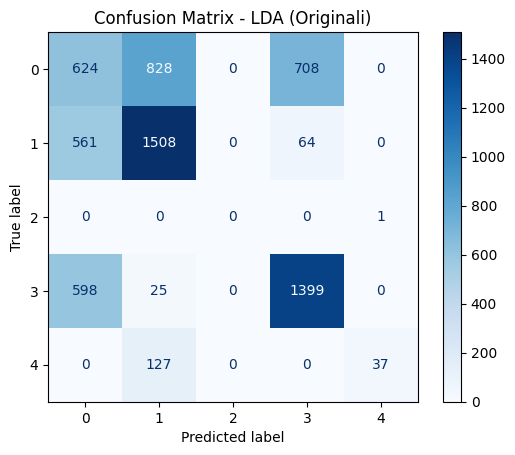

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,43.25,18.20,0.0,38.51,0.05
1,0,3,35.93,13.27,0.0,50.79,0.01
2,1,1,42.13,43.76,0.0,13.87,0.25
3,3,3,20.01,2.84,0.0,77.14,0.00
4,1,3,32.78,7.45,0.0,59.72,0.06
...,...,...,...,...,...,...,...
6475,0,3,10.12,0.63,0.0,89.25,0.00
6476,0,3,37.89,10.65,0.0,51.43,0.02
6477,1,0,46.35,34.18,0.0,19.11,0.36
6478,0,0,44.40,35.89,0.0,19.65,0.06


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,1.37,17.58,5.55,0.02,75.48


,Training Set,Test Set
Accuracy,0.818673,0.814352


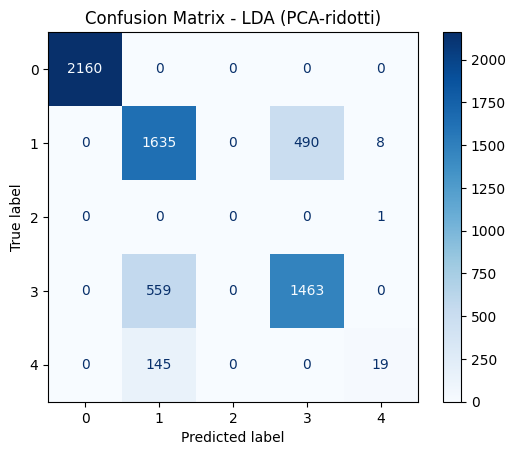

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,100.0,0.00,0.0,0.00,0.00
1,0,0,100.0,0.00,0.0,0.00,0.00
2,1,1,0.0,51.12,0.0,48.48,0.40
3,3,3,0.0,5.59,0.0,94.41,0.00
4,1,1,0.0,56.24,0.0,40.37,3.40
...,...,...,...,...,...,...,...
6475,0,0,100.0,0.00,0.0,0.00,0.00
6476,0,0,100.0,0.00,0.0,0.00,0.00
6477,1,1,0.0,56.25,0.0,42.57,1.18
6478,0,0,100.0,0.00,0.0,0.00,0.00


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.0,25.53,4.93,0.34,69.2


In [11]:
lda = LDA()

evaluate_and_plot(lda, X_train, y_train, X_test, y_test, name = "LDA (Originali)")
evaluate_and_plot(lda, X_train_pca, y_train, X_test_pca, y_test, name = "LDA (PCA-ridotti)")

# SVM

Non posso usare la Gridsearch perchè una classe ha solo un valore

,Training Set,Test Set
Accuracy,0.93071,0.933796


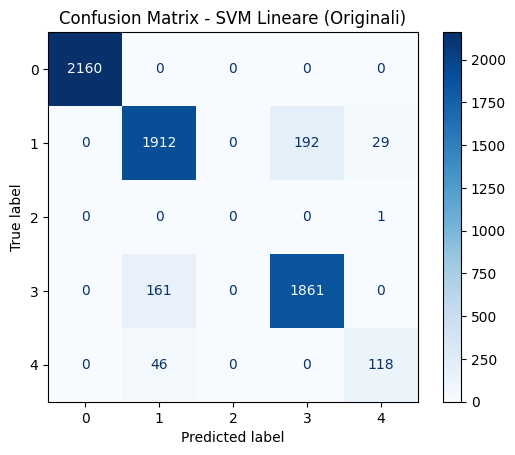

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.03,0.01,0.05,0.02
1,0,0,99.90,0.02,0.02,0.05,0.02
2,1,1,0.03,91.44,0.02,8.51,0.01
3,3,3,0.02,0.19,0.01,99.78,0.00
4,1,3,0.03,1.82,0.02,98.14,0.00
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.91,0.02,0.01,0.05,0.02
6477,1,1,0.08,71.93,0.07,25.19,2.73
6478,0,0,99.89,0.04,0.01,0.04,0.02


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.21,0.08,0.48,0.03,99.2


,Training Set,Test Set
Accuracy,0.831173,0.824383


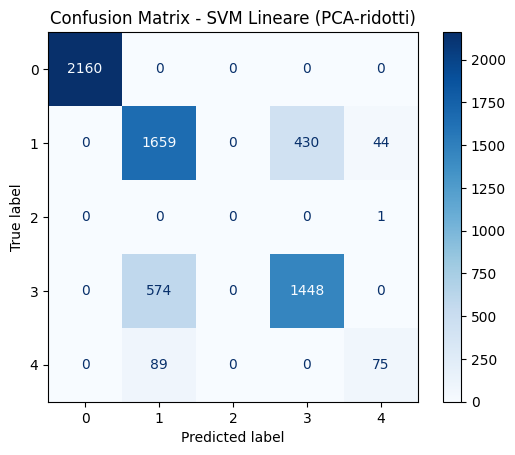

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.02,0.01,0.04,0.02
1,0,0,99.91,0.02,0.02,0.04,0.01
2,1,1,0.06,48.96,0.03,50.95,0.01
3,3,3,0.03,3.19,0.01,96.76,0.00
4,1,1,0.01,54.04,0.02,45.83,0.10
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.88,0.03,0.03,0.05,0.02
6477,1,1,0.01,52.33,0.03,47.53,0.10
6478,0,0,99.91,0.02,0.01,0.04,0.01


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.14,6.58,0.4,0.12,92.76


In [12]:
svc_linear = SVC(kernel='linear', C = 2, probability=True, random_state = 42)

evaluate_and_plot(svc_linear, X_train, y_train, X_test, y_test, name = "SVM Lineare (Originali)")
evaluate_and_plot(svc_linear, X_train_pca, y_train, X_test_pca, y_test, name = "SVM Lineare (PCA-ridotti)")

,Training Set,Test Set
Accuracy,0.999846,0.999846


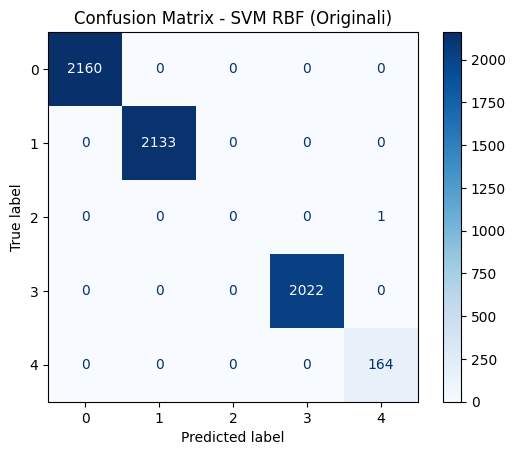

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.02,0.01,0.05,0.02
1,0,0,99.89,0.02,0.02,0.05,0.02
2,1,1,0.00,99.99,0.01,0.00,0.00
3,3,3,0.00,0.00,0.00,100.00,0.00
4,1,1,0.00,99.93,0.01,0.06,0.00
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.90,0.02,0.02,0.05,0.02
6477,1,1,0.00,99.83,0.02,0.16,0.00
6478,0,0,99.90,0.05,0.02,0.02,0.02


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.1,0.07,1.27,0.14,98.42


,Training Set,Test Set
Accuracy,0.942284,0.906173


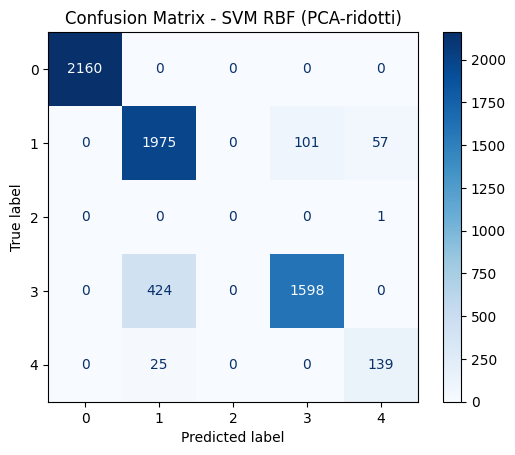

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.87,0.03,0.02,0.06,0.02
1,0,0,99.88,0.03,0.02,0.05,0.02
2,1,1,0.01,77.49,0.02,22.46,0.02
3,3,3,0.00,0.00,0.00,100.00,0.00
4,1,1,0.05,88.35,0.03,10.07,1.51
...,...,...,...,...,...,...,...
6475,0,0,99.88,0.03,0.02,0.05,0.02
6476,0,0,99.91,0.02,0.02,0.03,0.02
6477,1,1,0.03,85.13,0.02,14.81,0.01
6478,0,0,99.92,0.02,0.01,0.04,0.01


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.05,1.5,0.5,0.02,97.93


In [13]:
svc_rbf = SVC(kernel = 'rbf', C = 2, gamma = 'scale', probability = True, random_state = 42)

evaluate_and_plot(svc_rbf, X_train, y_train, X_test, y_test, name = "SVM RBF (Originali)")
evaluate_and_plot(svc_rbf, X_train_pca, y_train, X_test_pca, y_test, name = "SVM RBF (PCA-ridotti)")

# MLP

,Training Set,Test Set
Accuracy,1.0,0.999846


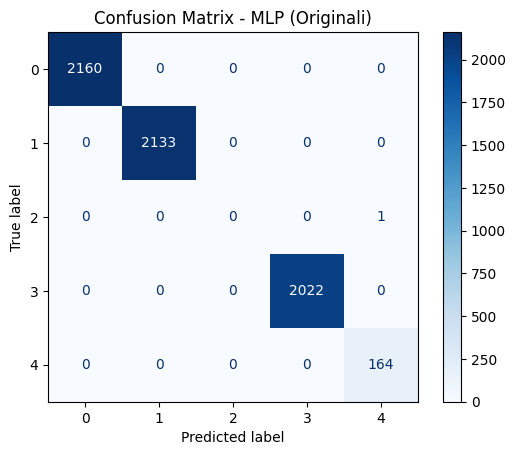

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,100.00,0.00,0.0,0.00,0.0
1,0,0,100.00,0.00,0.0,0.00,0.0
2,1,1,0.00,100.00,0.0,0.00,0.0
3,3,3,0.00,0.00,0.0,100.00,0.0
4,1,1,0.00,99.83,0.0,0.16,0.0
...,...,...,...,...,...,...,...
6475,0,0,100.00,0.00,0.0,0.00,0.0
6476,0,0,100.00,0.00,0.0,0.00,0.0
6477,1,1,0.00,99.99,0.0,0.01,0.0
6478,0,0,100.00,0.00,0.0,0.00,0.0


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.0,0.07,21.69,0.0,78.23


,Training Set,Test Set
Accuracy,0.999846,0.998457


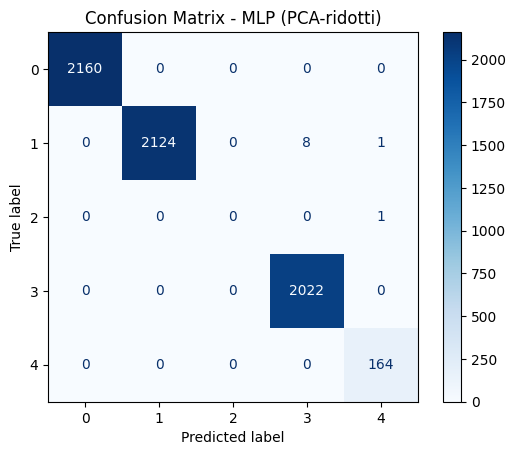

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,100.0,0.00,0.0,0.00,0.0
1,0,0,100.0,0.00,0.0,0.00,0.0
2,1,1,0.0,99.96,0.0,0.04,0.0
3,3,3,0.0,0.00,0.0,100.00,0.0
4,1,1,0.0,96.81,0.0,3.19,0.0
...,...,...,...,...,...,...,...
6475,0,0,100.0,0.00,0.0,0.00,0.0
6476,0,0,100.0,0.00,0.0,0.00,0.0
6477,1,1,0.0,99.90,0.0,0.10,0.0
6478,0,0,100.0,0.00,0.0,0.00,0.0


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.0,5.43,9.26,0.0,85.31


In [14]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

evaluate_and_plot(mlp_model, X_train, y_train, X_test, y_test, name="MLP (Originali)")
evaluate_and_plot(mlp_model, X_train_pca, y_train, X_test_pca, y_test, name="MLP (PCA-ridotti)")